06 CNNの可視化
=============

* CNNで用いられる畳み込み層は、"何を見ている"のか？

* ここでは、畳み込み層の可視化を通じて、CNNで何が行われているのかを探索する

## 1.1層目の重みの可視化

* MNISTデータセットに対して単純なCNNの学習を行なった

* その時、1層目の畳み込み層の重みの形状は、`(30, 1, 5, 5)`：サイズが$5 \times 5$、チャンネルが`1`のフィルターが30個

    * フィルターのサイズが$5 \times 5$でチャンネル数が`1`ということは、フィルターは1チャンネルのグレー画像として可視できる

* ここでは、畳み込み層(1層目)のフィルターを画像として表示してみる

    * ここでは、学習前と学習後の重みを見比べる

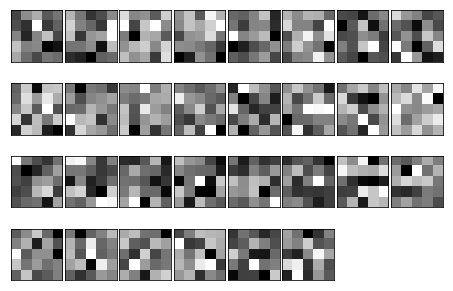

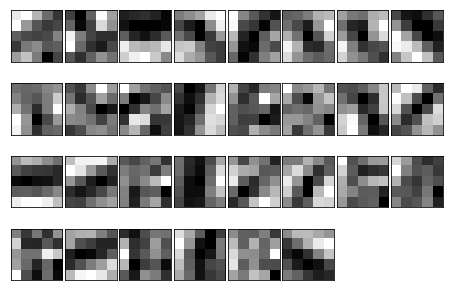

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
import matplotlib.pyplot as plt
%matplotlib inline

class SimpleConvNet:
    """単純なConvNet
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
        
        

network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])

* 上の図に示すように、学習前のフィルターはランダムに初期化されているため白黒の濃淡には規則性がない

* 一方、学習を終えたフィルターは規則性のある画像になっている

    * 白から黒へグラデーションを伴って変化するフィルター
    
    * 塊のある領域(ブロブ)を持つフィルター
    
    * これらのような、学習によって規則性のあるフィルターへと更新されている

* 右側のような規則性のあるフィルターは、以下のものを見ている

    * エッジ(色が変化する境目)
    
    * ブロブ(局地的に塊のある領域)
    
* 例)左半分が白で、右半分が黒のフィルターの場合、縦方向のエッジに対応するフィルターになる

* 下の図は、学習済みのフィルターを2つ選んで、入力画像に畳み込み処理を行なった時の結果を示している

    * 「フィルター1」：縦方向のエッジに反応
    
    * 「フィルター2」：横方向のエッジに反応
    
![横方向のエッジと縦方向のエッジに反応するフィルター](./images/横方向のエッジと縦方向のエッジに反応するフィルター.png)

* このように、畳み込み層のフィルターは、エッジやブロブなどのプリミティブな情報を抽出することがわかる

* そのようなプリミティブな情報が後段の層に渡されていくのが、CNNで行わていること

## 2.階層構造による情報抽出

* 上の結果は、1層目の畳み込み層を対象としたもの

    * 1層目の畳み込み層では、エッジやブロブなどの低レベルな情報が抽出される
    
    * 何層にも重ねたCNNでは、各層でどのような情報が抽出されるのか？
    
        * 層が深くなるにしたがって、抽出される情報がより抽出されることが示される
        
        * この情報は、正確には強く反応するニューロンのこと

* 下の図には、一般物体認識(車や犬など)を行う8層のCNNを示す

    * このネットワーク構造には、`AlexNet`という名前がついている
    
* `AlexNet`のネットワーク構成は、畳み込み層とプーリング層が何層にも重なり、最後に全結合層を経て結果が出力される

    * ブロックで示されているのは、中間データ
    
    * それらの中間データに対して畳み込み演算が連続的に適用される
    
![CNNの畳み込み層で抽出される情報](./images/CNNの畳み込み層で抽出される情報.png)

* ディープラーニングの興味深い点は、畳み込み層を何層も重ねると、層が深くなるに連れて、より複雑で抽象化された情報が抽出されること

    * 最初の層は単純なエッジに反応し、続いてテクスチャに反応し、そしてより複雑な物体のパーツへと反応するように変化する
    
    * つまり、層が深くなるに連れて、ニューロンは単純な形状から"高度"な情報へと変化する
    
    * 言い換えれば、モノの「意味」を理解するように、反応する対象が変化していく

| 版   | 年/月/日   |
| ---- | ---------- |
| 初版 | 2019/05/18 |